# Class Challenge: Image Classification of COVID-19 X-rays
# Task 1 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Binary Classification: COVID-19 vs. Normal

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13971354751123123693
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14215551580391265370
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


'2.1.0'

#### Load Image Data

In [2]:

DATA_LIST = os.listdir('two/train')
DATASET_PATH = 'two/train'
TEST_DIR = 'two/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 40
LEARNING_RATE = 0.0005 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')

train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="binary")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",seed=42,
                                                  class_mode="binary")

Found 104 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg_16 = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='None',
    classes=NUM_CLASSES
)
vgg_16.trainable = False
print(vgg_16.summary())
model = tf.keras.models.Sequential()
model.add(vgg_16)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### [5 points] Train Model

In [5]:
#FIT MODEL
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

print(device_lib.list_local_devices())

history = None

with tf.device("GPU:0"):
    history = model.fit_generator(generator=train_batches, 
                steps_per_epoch=STEP_SIZE_TRAIN, 
                epochs=NUM_EPOCHS, 
                validation_data=(valid_batches),
                validation_steps=STEP_SIZE_VALID)

11
3
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1780488732106218557
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4930941747
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2999473254753104819
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
Instructions for updating:
Please use Model.fit, which supports generators.


C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10 steps, validate for 2 steps
Epoch 1/40


C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\tanzi\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


10/10 [==============================] - 5s 500ms/step - loss: 5.4536 - accuracy: 0.5319 - val_loss: 0.9881 - val_accuracy: 0.4500
Epoch 2/40
10/10 [==============================] - 4s 367ms/step - loss: 0.7348 - accuracy: 0.6064 - val_loss: 0.5896 - val_accuracy: 0.6000
Epoch 3/40
10/10 [==============================] - 4s 357ms/step - loss: 0.4700 - accuracy: 0.7340 - val_loss: 0.0904 - val_accuracy: 1.0000
Epoch 4/40
10/10 [==============================] - 4s 364ms/step - loss: 0.2324 - accuracy: 0.8830 - val_loss: 0.0839 - val_accuracy: 1.0000
Epoch 5/40
10/10 [==============================] - 4s 360ms/step - loss: 0.2630 - accuracy: 0.8830 - val_loss: 0.0245 - val_accuracy: 1.0000
Epoch 6/40
10/10 [==============================] - 4s 364ms/step - loss: 0.1692 - accuracy: 0.9362 - val_loss: 0.5900 - val_accuracy: 0.8500
Epoch 7/40
10/10 [==============================] - 4s 353ms/step - loss: 0.3346 - accuracy: 0.8617 - val_loss: 0.5325 - val_accuracy: 0.8000
Epoch 8/40
10/10 

#### [5 points] Plot Accuracy and Loss During Training

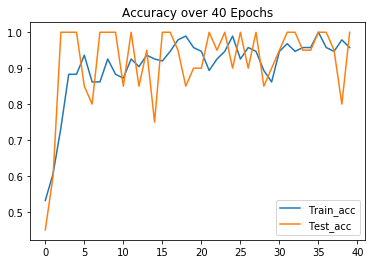

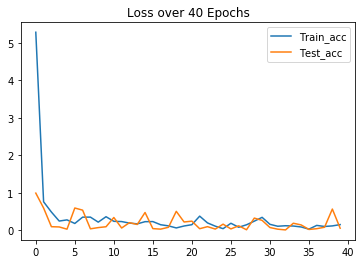

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['accuracy'], label='Train_acc')
plt.plot(history.history['val_accuracy'], label='Test_acc')
plt.title("Accuracy over 40 Epochs")
plt.legend(loc='lower right')

plt.figure()
plt.plot(history.history['loss'], label='Train_acc')
plt.plot(history.history['val_loss'], label='Test_acc')
plt.title("Loss over 40 Epochs")
plt.legend(loc='upper right')

#### Plot Test Results

Found 18 images belonging to 2 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
18/18 [==============================] - 1s 50ms/step
covid\nejmoa2001191_f3-PA.jpeg


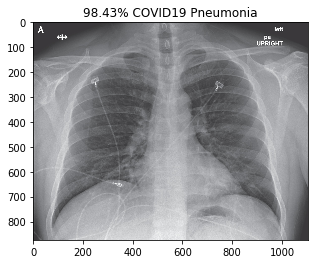

covid\nejmoa2001191_f4.jpeg


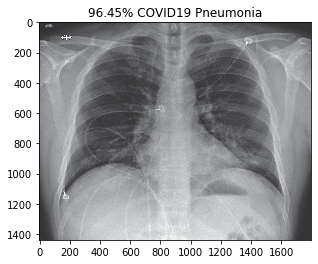

covid\nejmoa2001191_f5-PA.jpeg


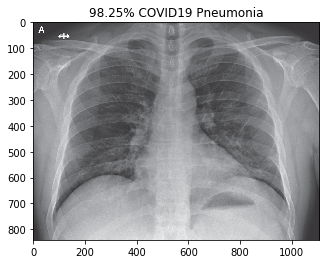

covid\radiol.2020200490.fig3.jpeg


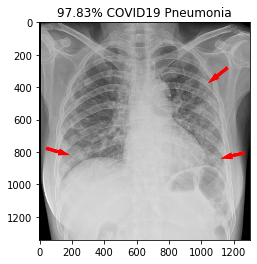

covid\ryct.2020200028.fig1a.jpeg


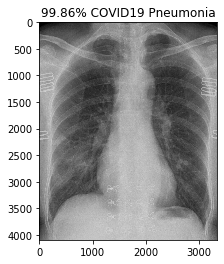

covid\ryct.2020200034.fig2.jpeg


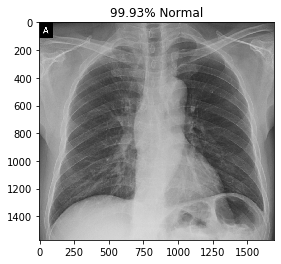

covid\ryct.2020200034.fig5-day0.jpeg


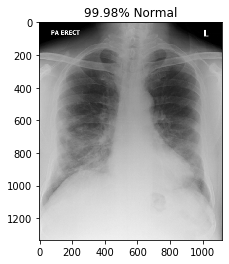

covid\ryct.2020200034.fig5-day4.jpeg


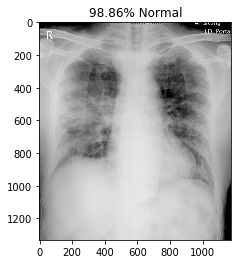

covid\ryct.2020200034.fig5-day7.jpeg


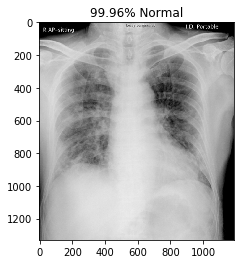

normal\NORMAL2-IM-1385-0001.jpeg


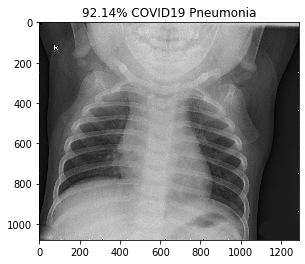

normal\NORMAL2-IM-1396-0001.jpeg


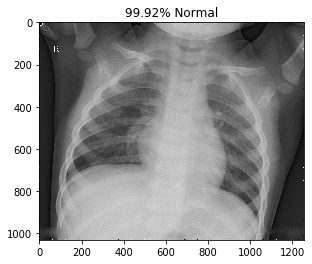

normal\NORMAL2-IM-1400-0001.jpeg


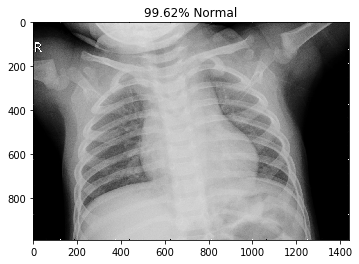

normal\NORMAL2-IM-1401-0001.jpeg


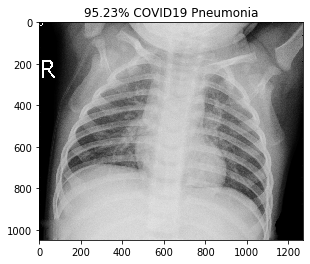

normal\NORMAL2-IM-1406-0001.jpeg


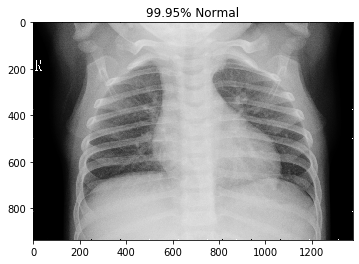

normal\NORMAL2-IM-1412-0001.jpeg


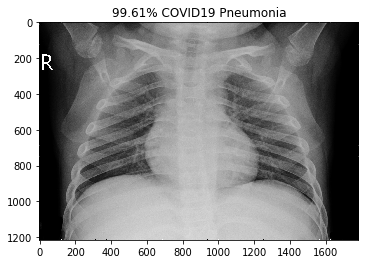

normal\NORMAL2-IM-1419-0001.jpeg


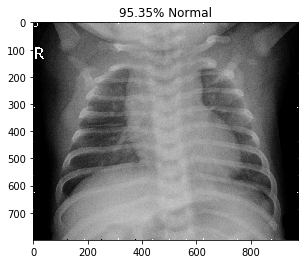

normal\NORMAL2-IM-1422-0001.jpeg


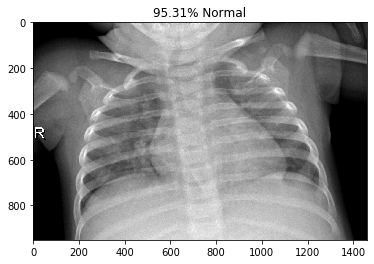

normal\NORMAL2-IM-1423-0001.jpeg


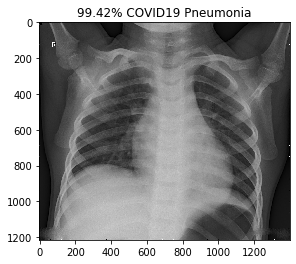

In [7]:
import matplotlib.image as mpimg

test_datagen = ImageDataGenerator(rescale=1. / 255)
eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,batch_size=1,shuffle=True,seed=42,class_mode="binary")
eval_generator.reset()
pred = model.predict_generator(eval_generator,18,verbose=1)
for index, probability in enumerate(pred):
    image_path = TEST_DIR + "/" +eval_generator.filenames[index]
    image = mpimg.imread(image_path)
    if image.ndim < 3:
        image = np.reshape(image,(image.shape[0],image.shape[1],1))
        image = np.concatenate([image, image, image], 2)
#         print(image.shape)

    pixels = np.array(image)
    plt.imshow(pixels)
    
    print(eval_generator.filenames[index])
    if probability > 0.5:
        plt.title("%.2f" % (probability[0]*100) + "% Normal")
    else:
        plt.title("%.2f" % ((1-probability[0])*100) + "% COVID19 Pneumonia")
    plt.show()

## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 130 images belonging to 2 classes.
130/130 [==============================] - 3s 24ms/step


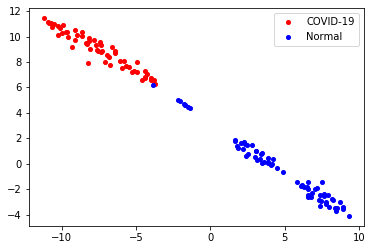

In [13]:
from sklearn.manifold import TSNE

intermediate_layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('dense_1').output)
tsne_data_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE, batch_size=1,shuffle=False,seed=42,class_mode="binary")

outputs = intermediate_layer_model.predict_generator(tsne_data_generator,130,verbose=1)
label = tsne_data_generator.classes
features = TSNE(n_components=2).fit_transform(outputs)

COVID_19_value_x, COVID_19_value_y = [], []
Normal_value_x, Normal_value_y = [], []

plt.figure()
for index in range(len(features)):
    if label[index] == 0:
        COVID_19_value_x.append(features[index, 0])
        COVID_19_value_y.append(features[index, 1])
    else:
        Normal_value_x.append(features[index, 0])
        Normal_value_y.append(features[index, 1])
        
plt.plot(COVID_19_value_x,COVID_19_value_y, 'ro', markersize=4, label="COVID-19")
plt.plot(Normal_value_x,Normal_value_y, 'bo', markersize=4, label="Normal")

plt.legend(loc='upper right')



<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->